In [25]:
from docopt import docopt
import logging
import os
import hashlib
import glob
import getpass
import socket
import datetime
import re
import requests
from slimit.lexer import Lexer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import manifold
from sklearn import cross_validation
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


class Database():
    """A directory structure containing JavaScript samples and associated metadata"""
    def __init__(self, path):
        """Load or create the Database at path"""
        self.path = path
        self.subdirs = [self.path+'/'+sdir for sdir in ['malicious', 'legitimate', 'unknown']]
        if not self.check():
            self.create()

    def check(self):
        """Check if the database exists and contains the needed subdirs"""
        if not os.path.isdir(self.path):
            return False
        if not all(map(os.path.isdir, self.subdirs)):
            return False
        return True

    def create(self):
        """Create the directory structure needed to host a database"""
        for sdir in self.subdirs:
            os.makedirs(sdir)

    def lookup(self, sha1):
        """Return the snippet with the provided sha1, if it exists in the database"""
        logging.debug('Looking for snippet '+sha1)
        files=sum([glob.glob(sdir+'/*.js') for sdir in self.subdirs], [])
        matching_files = [f for f in files if os.path.basename(f)[:-3] == sha1]
        assert len(matching_files) <= 1, "Multiple snippets of the same hash in the DB"
        if matching_files:
            fname = matching_files[0]
            logging.debug('Found')
            return Snippet(filename=matching_files[0])
        logging.debug('Not found')
        return None

    def add_new(self, snippet, message):
        """Add to the database a snippet that wasn't there before, return the newly created snippet"""
        fname = self.path+'/'+snippet.status+'/'+snippet.sha1+'.js'
        with open(fname, 'wb') as f:
            f.write(snippet.data)
        snippet.filename = fname
        snippet.log(event='created', message=message)
        return snippet

    def move(self, snippet, status, message):
        """Moves an existing snippet from its status to another"""
        path = snippet.filename.split('/')
        new_name = '/'.join(path[:-2]+[status, path[-1]])
        os.rename(snippet.filename, new_name)
        #Now moving the logs
        os.rename(snippet.filename[:-2]+'log', new_name[:-2]+'log')
        snippet.filename = new_name
        old_status = snippet.status
        snippet.status = status
        snippet.log(event='moved from '+old_status, message=message)
        
    def legitimate_snippets(self):
        """The legitimate snippets in the DB"""
        return [Snippet(filename=fname) for fname in sorted(glob.glob(self.path+'/legitimate/*.js'))]
    
    def malicious_snippets(self):
        """The malicious snippets in the DB"""
        return [Snippet(filename=fname) for fname in sorted(glob.glob(self.path+'/malicious/*.js'))]
    
        
class Snippet():
    """A JavaScript snippet"""

    log_template = "{date} {severity} hostname={hostname} user={user} sha1={sha1} status={status} event={event} message={message}\n"

    def __init__(self, filename=None, status='unknown', sha1=None, data=None):
        """Create a new snippet instance, either from data and status, or from a file in a DB"""
        self.data = data
        if filename:
            self.loadFromFile(filename)
            return
        if not sha1:
            self.sha1 = hashlib.sha1(self.data).hexdigest()
        else:
            self.sha1 = sha1
        self.status = status

    def loadFromFile(self, fname):
        """Load a snippet from a file in a DB"""
        self.filename = fname
        self.__init__(data=open(fname, 'r').read(), status=fname.split('/')[-2], sha1=fname.split('/')[-1][:-3])

    def log(self, event, message):
        """Append a line to the snippet's log file"""
        if not self.filename:
            raise ValueError("We don't know which DB we belong to.")
        severity='ERROR:' if 'bad move' in event else 'WARNING:' if 'moved' in event else 'INFO:'
        log_message = self.log_template.format(date=datetime.datetime.now().isoformat(),
                                               severity=severity,
                                               hostname=socket.gethostname(),
                                               user=getpass.getuser(),
                                               sha1=self.sha1,
                                               status=self.status,
                                               event=event,
                                               message=message if message else '')
        log_fname = self.filename[:-3]+'.log'
        with open(log_fname, 'a') as f:
            f.write(log_message)



In [2]:
db = Database('sekoia_db')

In [3]:
def train_from_js_tokens(corpus):
    tokens_corpus = []
    for t in corpus:
        print('INFO: Parsing '+t.filename)
        try:
            lexer = Lexer()
            lexer.input(t.data)
            tokens_corpus.append(' '.join([token.type for token in lexer]))
        except TypeError as e:
            print('Error lexing '+t.filename+' : '+str(e))
    return train_tfidf(tokens_corpus)


In [4]:
def train_tfidf(corpus):
    '''Return the tf_idf transformer trained on the supplied corpus

    Args:
        corpus (list): List of text elements'''
    count_vect = CountVectorizer()
    train_counts = count_vect.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer().fit(train_counts)
    def text2tfidf(text_list):
        '''Transform a list of text into a tfidf matrix'''
        return tfidf_transformer.transform(count_vect.transform(text_list)).toarray()
    return text2tfidf


In [5]:
corpus = db.legitimate_snippets()+db.malicious_snippets()
tfidf_transformer = train_from_js_tokens(corpus)

INFO: Parsing sekoia_db/legitimate/0034c7dacfeb469c20f9fb8bcad407a6dc82937b.js
INFO: Parsing sekoia_db/legitimate/0a7e9f4c559853b7d1bb10d045b93e207150283a.js
INFO: Parsing sekoia_db/legitimate/12717789ff0f8512728ec437724b90b4698cf718.js
INFO: Parsing sekoia_db/legitimate/1852661bd11a09ca9b9cb63d1aa6ff390fffaf4e.js
INFO: Parsing sekoia_db/legitimate/2674a226732a96f20320ae4b3233bdf9476ff218.js
INFO: Parsing sekoia_db/legitimate/27aa8ddb0c9457d659c51806103741b163f4650a.js
INFO: Parsing sekoia_db/legitimate/2e1a413df833abd6e09088d1e7f4f7507b156995.js
INFO: Parsing sekoia_db/legitimate/32ea2acd3d51248716d70e26b047efe35099d0ce.js
INFO: Parsing sekoia_db/legitimate/33dbfc1abb4f98ede991f25fb9882f286b900e4d.js
INFO: Parsing sekoia_db/legitimate/3a9910396919f0542104a28fb3e7edbaa19bc317.js
INFO: Parsing sekoia_db/legitimate/3f36e7886f2e5d26b3537cc04d5bebdec3762f59.js
INFO: Parsing sekoia_db/legitimate/4125aeafb14e79f2924405f48d11369594b5aab6.js
INFO: Parsing sekoia_db/legitimate/44fd3f7462bfc6d8e

In [6]:
X_0 = tfidf_transformer([s.data for s in db.legitimate_snippets()])

In [9]:
X_1 = tfidf_transformer([s.data for s in db.malicious_snippets()])
X = np.vstack([X_0, X_1])
Y =np.zeros(len(X))
Y[-len(X_1):] = 1

In [10]:
def clf_eval(clf, X, Y):
    loo = cross_validation.LeaveOneOut(len(Y))
    Y_true = []
    Y_pred = []
    for train_index, test_index in loo:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        Y_pred.append(clf.predict(X_test))
        Y_true.append(Y_test)
    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)
    cm =  metrics.confusion_matrix(Y_true, Y_pred)
    print("Overall accuracy : "+str(sum(Y_true == Y_pred)/len(Y_true)))
    return cm


In [11]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

results = {}
for str_clf in ['LinearSVC', 'KNeighborsClassifier', 'SVC', 'BaggingClassifier', 'RandomForestClassifier',
                'ExtraTreesClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']:
    clf = eval(str_clf+'()')
    print("Evaluating "+str_clf+"...")
    results[str_clf] = clf_eval(clf, X, Y)

Evaluating LinearSVC...
Overall accuracy : [ 0.97297297]
Evaluating KNeighborsClassifier...
Overall accuracy : [ 0.93243243]
Evaluating SVC...
Overall accuracy : [ 0.59459459]
Evaluating BaggingClassifier...
Overall accuracy : [ 0.95945946]
Evaluating RandomForestClassifier...
Overall accuracy : [ 1.]
Evaluating ExtraTreesClassifier...
Overall accuracy : [ 0.97297297]
Evaluating AdaBoostClassifier...
Overall accuracy : [ 0.94594595]
Evaluating GradientBoostingClassifier...
Overall accuracy : [ 0.94594595]


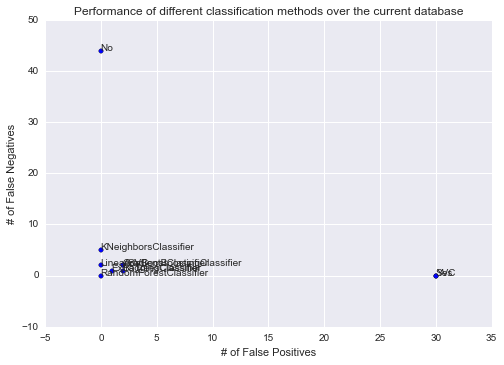

In [21]:
results_fpfn = {}
results_fpfn['Yes'] = [len(X_0),0]
results_fpfn['No'] = [0, len(X_1)]
for k in results:
    results_fpfn[k] = [results[k][0,1], results[k][1,0]]
for k in results_fpfn:
    plt.scatter(results_fpfn[k][0], results_fpfn[k][1])
    plt.text(results_fpfn[k][0], results_fpfn[k][1], k)
plt.title("Performance of different classification methods over the current database")
plt.xlabel("# of False Positives")
plt.ylabel("# of False Negatives")

In [27]:
def single_projection(X, s, l, color, labels=None):
    Y = l.fit_transform(X)
    plt.title(s)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, alpha=0.7)
    plt.axis('tight')
    if labels:
        place_labels(labels, Y)

def project_on_plane(X, color, n_neighbors = 10, n_components = 2, title='2D projection', unique=None, labels=None):
    '''Give multiple 2D representations of a high-dimenstional dataset

    See http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html'''
    fig = plt.figure(figsize=(15,8))
    learners = [['Isomap', manifold.Isomap(n_neighbors, n_components)],
                ['LLE', manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto')],
                ['LTSA', manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto', method='ltsa')],
                ['Hessian', manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto', method='hessian')],
                ["Modified", manifold.LocallyLinearEmbedding(n_neighbors, n_components, eigen_solver='auto', method='hessian')],
                ["MDS", manifold.MDS(n_components, max_iter=100, n_init=1)],
                ["Spectral Embedding", manifold.SpectralEmbedding(n_components=n_components,n_neighbors=n_neighbors)],
                ["t-SNE", manifold.TSNE(n_components=n_components, init='pca', random_state=0)]
                ]
    fig_num = 331
    if unique:
        s,l = [x for x in learners if x[0] == unique][0]
        single_projection(X, s, l, color, labels)
    else:
        for s, l in learners:
            ax = fig.add_subplot(fig_num)
            fig_num += 1
            single_projection(X, s, l, color, labels)
    plt.savefig(title+'.pdf')
    plt.show()



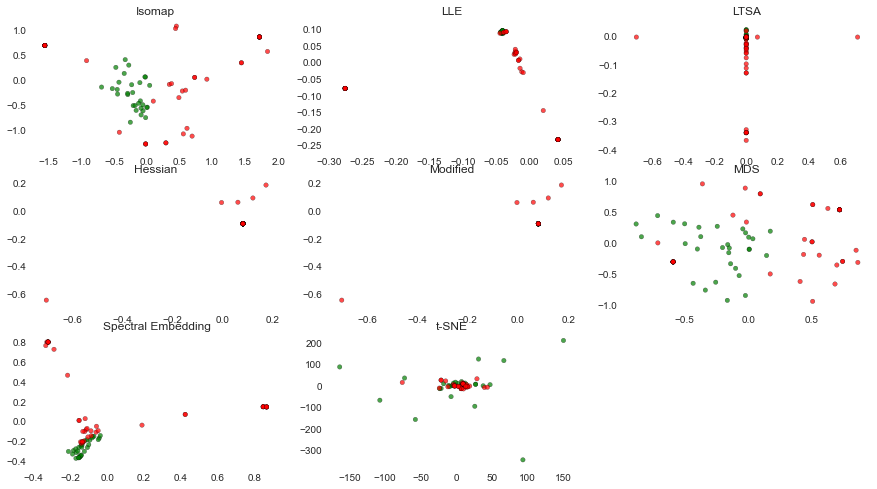

In [28]:
project_on_plane(X, ['r' if c == 1 else 'g' for c in Y])

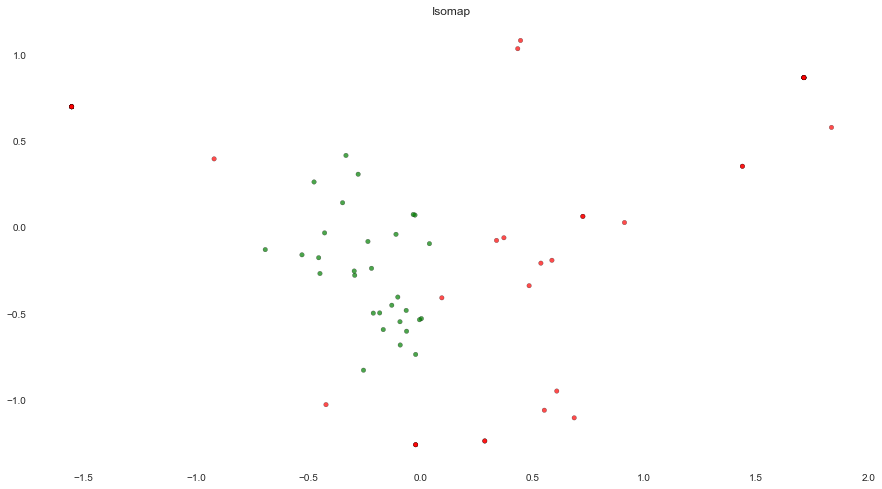

In [29]:
project_on_plane(X, ['r' if c == 1 else 'g' for c in Y], unique='Isomap')

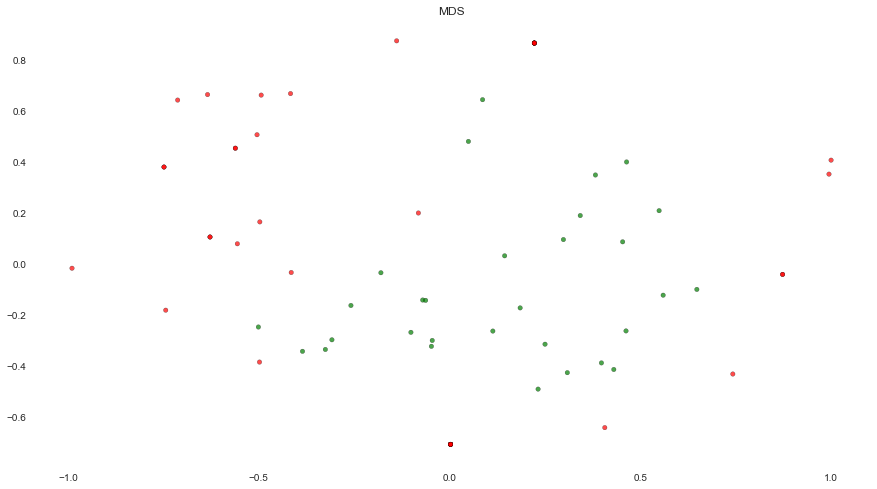

In [30]:
project_on_plane(X, ['r' if c == 1 else 'g' for c in Y], unique='MDS')

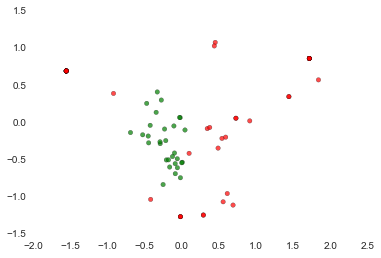

In [35]:
Y2d = manifold.Isomap(10, 2).fit_transform(X)
plt.scatter(Y2d[:, 0], Y2d[:, 1], c=['r' if c == 1 else 'g' for c in Y], alpha=0.7)


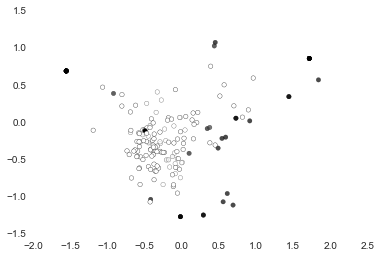

In [73]:
clf = RandomForestClassifier().fit(X,Y)
isomap = manifold.Isomap(10, 2)
Y2d = isomap.fit_transform(X)
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(X)
else:
    Z = clf.predict_proba(X)[:, 1]
plt.scatter(Y2d[:, 0], Y2d[:, 1], c=Z, alpha=0.7)
x_min = X.min(0)
x_span = X.max(0)-X.min(0)
rand_points = []
for i in range(0,100):
    r = np.random.random(len(x_min))*x_span - x_min
    rand_points.append(r)
rand_points = np.array(rand_points)
if hasattr(clf, "decision_function"):
    rand_values = clf.decision_function(rand_points)
else:
    rand_values = clf.predict_proba(rand_points)[:, 1]
Ybis2d = isomap.transform(rand_points)
plt.scatter(Ybis2d[:,0], Ybis2d[:,1], c=rand_values)

In [86]:
zi[:,:,0].shape

(500, 500)

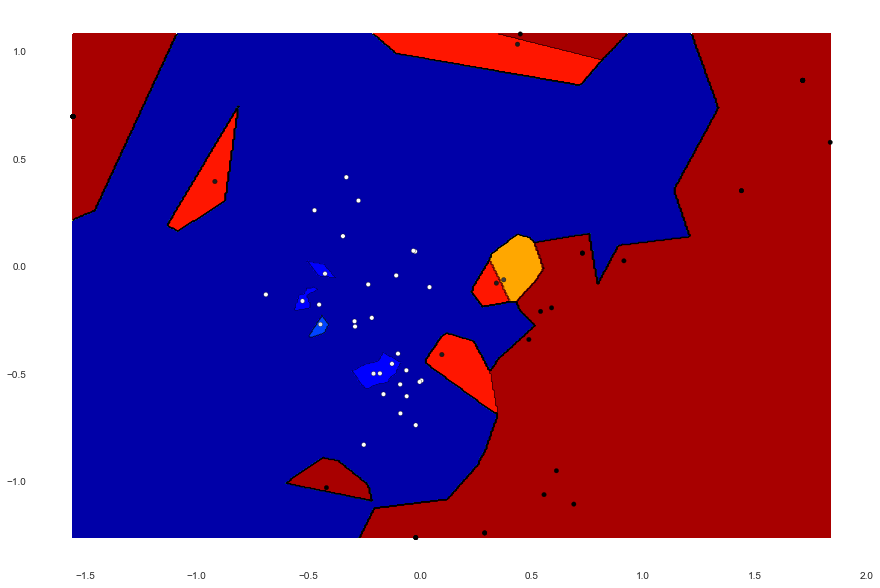

In [88]:
plt.figure(figsize=(15,10))
from scipy.interpolate import griddata
_Y = np.vstack([Y2d, Ybis2d])
_Z = np.vstack([Z[:,None], rand_values[:,None]])
xi = np.linspace(_Y[:,0].min(), _Y[:,0].max(), 500)
yi = np.linspace(_Y[:,1].min(), _Y[:,1].max(), 500)
zi = griddata(_Y, _Z, (xi[None,:], yi[:,None]), method='nearest')
CS = plt.contour(xi,yi,zi[:,:,0],15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi[:,:,0],15,cmap=plt.cm.jet)
plt.scatter(Y2d[:, 0], Y2d[:, 1], c=Z)
plt.savefig('Picasso.png')